# Import Packages and Data

In [92]:
# import necessary libraries
import numpy as np
from scipy.spatial import distance_matrix
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.sql.functions import explode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# instantiate SparkSession object
spark = SparkSession\
        .builder\
        .appName("ALSExample").config("spark.driver.host","localhost")\
        .getOrCreate()

In [4]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('../data/test_data/ratings.csv', header='true', inferSchema = 'true')


In [6]:
movie_ratings = movie_ratings.drop('timestamp')


# Grid Search Optimal Hyperparameters with Cross Validation

In [119]:
als_model =  ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
               
params = ParamGridBuilder().addGrid(als_model.regParam, [0.1, 0.01, 0.001]).addGrid(als_model.rank, [39, 40, 41]).build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
## instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

In [120]:
predictions = best_model.transform(movie_ratings)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.5021018527870579


In [121]:
rank = best_model.bestModel.rank
rank

40

# Get Movie Data

In [122]:
movie_titles = spark.read.csv('../data/test_data/movies.csv',header='true',inferSchema='true')

movie_titles.head(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [123]:
def name_retriever(movie_id,movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [124]:
print(name_retriever(1023,movie_titles))

Winnie the Pooh and the Blustery Day (1968)


# New User Data

In [125]:
user_id = 100000
user_ratings_1 = [(user_id,3253,5),
                  (user_id,2459,5),
                  (user_id,2513,4),
                  (user_id,6502,5),
                  (user_id,1091,5),
                  (user_id,441,4)]

## Run Model with full data using parameters from grid search

In [126]:
user_factors = best_model.bestModel.userFactors
user_factors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.75721425, 0.09...|
| 20|[0.21885648, -0.0...|
| 30|[0.13208525, -0.3...|
| 40|[0.39490467, -0.1...|
| 50|[0.0041677905, -0...|
| 60|[-0.033292256, -0...|
| 70|[0.051805474, -0....|
| 80|[-0.027637867, -0...|
| 90|[0.09830346, -0.1...|
|100|[0.26058716, -0.0...|
|110|[0.19070025, -0.3...|
|120|[0.23393418, -0.1...|
|130|[0.067798205, 0.1...|
|140|[0.040666062, -0....|
|150|[0.12266327, -0.1...|
|160|[0.06314997, 0.25...|
|170|[0.32156283, 0.11...|
|180|[0.07727287, -0.0...|
|190|[0.16440234, -0.2...|
|200|[0.06835866, -0.2...|
+---+--------------------+
only showing top 20 rows



In [127]:
recommendationsDF = (user_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

display(recommendationsDF.show())

+---+-----------+
| id|   features|
+---+-----------+
| 10| 0.75721425|
| 10| 0.09838023|
| 10|-0.15136099|
| 10| 0.27100703|
| 10|-0.14083551|
| 10| -0.6613315|
| 10| 0.21919066|
| 10|-0.26339653|
| 10|-0.48047698|
| 10|-0.08198638|
| 10| 0.58646804|
| 10|0.025875332|
| 10|  0.2598667|
| 10| 0.13974541|
| 10| 0.12238094|
| 10|-0.35542864|
| 10| 0.44762185|
| 10| 0.45282352|
| 10| -0.2901792|
| 10| 0.64372545|
+---+-----------+
only showing top 20 rows



None

In [128]:
rec_pdf = recommendationsDF.toPandas()
rec_pdf.head()

,id,features
0,10,0.757214
1,10,0.098380
2,10,-0.151361
3,10,0.271007
4,10,-0.140836


In [129]:
multiplier = rec_pdf['id'].nunique()
feature_array = np.array(list(range(1,rank+1))*multiplier)
rec_pdf['value'] = feature_array

In [130]:
rec_pdf_unstacked = rec_pdf.pivot(index='id', columns='value', values='features')

In [131]:
rec_pdf_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
id,,,,,,,,,,,,,,,,,,,,,
1,0.152422,-0.388357,-0.020261,-0.283895,-0.715581,-0.275820,-0.594424,-0.476061,-0.327073,-0.107175,...,-0.054953,-0.015482,-0.524651,-0.162646,0.449809,-0.198844,-0.488369,-0.371684,-0.273140,0.503408
2,-0.237267,0.018162,0.056333,-0.291305,-0.297686,-0.256041,-0.357642,-0.010852,0.023825,-0.329933,...,0.275354,-0.108523,-0.203121,-0.412085,0.598562,-0.448977,-0.329342,-0.249044,-0.055596,0.046154
3,-0.336759,-0.111801,0.336275,-0.745783,-0.453100,0.066661,-0.234474,0.256798,0.003317,0.316405,...,0.009796,-0.606867,-0.127051,-0.652710,0.149232,0.561499,-0.490334,-0.257493,0.051059,-0.298589
4,0.381893,-0.361896,-0.233280,0.028443,0.253336,-0.381792,-0.271920,-0.854999,-0.414271,-0.209928,...,0.408159,0.169899,-0.041228,0.090021,0.461783,-0.038786,-0.597302,-0.275941,0.141380,-0.275522
5,-0.050191,-0.093985,0.091466,-0.025109,-0.007474,-0.122351,-0.437169,-0.550077,-0.641290,-0.241411,...,-0.290334,0.158503,-0.327093,0.291749,0.183384,-0.171913,-0.592679,-0.377109,0.010451,0.071565


# Hierarchical Agglomerative Cluster Analysis

In [132]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rec_pdf_scaled = scaler.fit_transform(rec_pdf_unstacked)

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


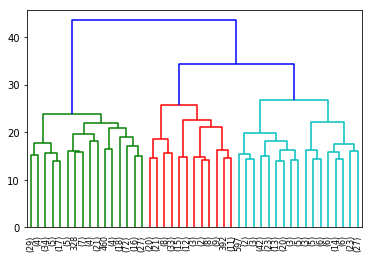

In [142]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline

z = linkage(rec_pdf_scaled, 'ward') # Ward linkage used to produce tightly knit clusters
c, coph_dist = cophenet(z, pdist(rec_pdf_scaled))
dendrogram(z,
          leaf_rotation=90,
          leaf_font_size = 8.,
          truncate_mode='lastp',
          p=45)
plt.show()

In [152]:
coph_dist.sort()
set(coph_dist)

{2.505244685211632,
 2.8041291772056223,
 2.8338208207605082,
 2.8922828929996256,
 2.9475760880240203,
 2.964347910736877,
 3.0400407907897997,
 3.0945649348076474,
 3.2108384875985254,
 3.2327899353118084,
 3.2748810623614517,
 3.288005745839433,
 3.329387922503637,
 3.335587821195264,
 3.3463563631363664,
 3.3526302596443966,
 3.4218806987266146,
 3.472199194779538,
 3.484825834299883,
 3.503660173177239,
 3.5874516398800136,
 3.6527849877163034,
 3.6766627409289754,
 3.6934429984412467,
 3.704398678693123,
 3.726789674263916,
 3.732195033740801,
 3.73450233898148,
 3.7572450839683316,
 3.7885153926106816,
 3.79428092667249,
 3.799817958763716,
 3.808879945930789,
 3.829012867841779,
 3.8328970740306474,
 3.8430688862898186,
 3.851436050033009,
 3.869807436133332,
 3.9060924471418943,
 3.90647314049647,
 3.908347724114149,
 3.9109490197259356,
 3.915865277542939,
 3.9281294131101867,
 3.9443450532317716,
 3.9491069244541745,
 3.9837386684969904,
 3.99672513372111,
 3.997228932498058

In [226]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
import pandas as pd
rec_pdf_clustered = pd.DataFrame(rec_pdf_scaled.copy())
cluster = AgglomerativeClustering(n_clusters=3, 
                                 affinity='euclidean',
                                 linkage='ward')
rec_pdf_clustered['cluster'] = cluster.fit_predict(rec_pdf_scaled)

In [227]:
rec_pdf_clustered.groupby(['cluster']).agg(['mean', 'std', 'count'])

0                         1                         2   \
             mean       std count      mean       std count      mean   
cluster                                                                 
0       -0.279205  0.884507   202 -0.034845  0.950215   202 -0.167976   
1        0.044079  0.996678   265  0.032767  0.964510   265  0.305037   
2        0.312716  1.062327   143 -0.011499  1.133277   143 -0.327996   

                               3   ...    36        37                  \
              std count      mean  ... count      mean       std count   
cluster                            ...                                   
0        0.985397   202 -0.003349  ...   202 -0.176525  1.021008   202   
1        0.865683   265 -0.189667  ...   265 -0.061951  0.902624   265   
2        1.098151   143  0.356212  ...   143  0.364161  1.058508   143   

               38                        39                  
             mean       std count      mean       std count  
cluster                                                      
0        0.012427  0.940287   202  0.067063  1.074367   202  
1       -0.083900  1.029903   265 -0.115964  0.888570   265  
2        0.137925  1.019687   143  0.120166  1.071436   143  

[3 rows x 120 columns]

In [228]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111, projection='3d')
# plt.scatter(rec_pdf_clustered[1], rec_pdf_clustered[5], rec_pdf_clustered[3], c=rec_pdf_clustered.cluster)
# plt.show();

In [229]:
cluster_centroids = rec_pdf_clustered.groupby(['cluster']).agg('mean')

In [230]:
cluster_centroids_array = cluster_centroids.to_numpy()

In [231]:
cluster_distance_matrix = distance_matrix(cluster_centroids_array, cluster_centroids_array, p=2)

In [232]:
cluster_distance_df = pd.DataFrame(cluster_distance_matrix)
cluster_distance_df

,0,1,2
0,0.000000,2.522507,2.658146
1,2.522507,0.000000,3.222755
2,2.658146,3.222755,0.000000


In [233]:
def nearest_clusters(cluster, num_nearest_clusters=2):
    sorted_distances = cluster_distance_df[cluster].sort_values(ascending=True)
    return sorted_distances[1:num_nearest_clusters+1].index.values.astype(int)

In [234]:
nearest_clusters(0, 2)

array([1, 2])

# KNN Model (for assigning new user to a cluster)

In [235]:
rec_pdf_clustered.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,cluster
0,0.384418,-1.135914,-0.359699,-0.880610,-2.145598,0.184374,-1.426277,-0.919439,-0.403021,0.926918,...,-0.809021,-1.282101,0.412244,0.001719,-0.442013,0.138978,0.054052,-0.931878,0.826101,0
1,-1.701330,1.151062,0.023881,-0.914696,-0.262587,0.287174,-0.261462,1.150977,1.237029,-0.237941,...,-1.337210,0.324023,-0.831614,0.736844,-1.691525,1.000970,0.636877,0.147863,-1.516605,0
2,-2.233842,0.419921,1.425820,-3.005429,-0.962874,1.964419,0.344447,2.342154,1.141176,3.141924,...,-4.166274,0.704012,-2.031520,-1.483700,3.356195,0.128328,0.596724,0.677226,-3.282869,0
3,1.612623,-0.987047,-1.426490,0.556240,2.220286,-0.366413,0.160232,-2.605905,-0.810572,0.389595,...,0.243370,1.132720,1.672201,0.060895,0.357540,-0.451484,0.509052,1.125517,-3.164689,1
4,-0.700036,0.520148,0.199825,0.309886,1.045090,0.982029,-0.652682,-1.248849,-1.871628,0.224961,...,0.178679,-0.295251,2.678140,-1.314925,-0.307483,-0.426423,0.028272,0.475675,-1.386414,1


In [236]:
X = rec_pdf_clustered.iloc[:,:-1]
y = rec_pdf_clustered.iloc[:,-1]

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [244]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
train_preds = knn.predict(X_train)
accuracy_score(y_train, train_preds)

1.0

In [245]:
test_preds = knn.predict(X_test)
accuracy_score(y_test, test_preds)

0.738562091503268

# Item Feature Extraction

In [33]:
item_factors = best_model.bestModel.itemFactors
item_factors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.055006977, 0.1...|
| 20|[-0.06451309, -0....|
| 30|[0.06327641, -0.0...|
| 40|[0.23264122, 0.10...|
| 50|[0.056452975, 0.1...|
| 60|[0.033397585, 0.2...|
| 70|[0.7093014, -0.04...|
| 80|[-0.001937247, 0....|
|100|[-0.0018683253, 0...|
|110|[-0.031771, 0.233...|
|140|[-0.23762299, -0....|
|150|[-0.07209138, 0.3...|
|160|[-0.19256663, 0.2...|
|170|[0.0017873142, 0....|
|180|[0.14999405, 0.34...|
|190|[0.08148454, -0.0...|
|210|[-0.19414307, 0.3...|
|220|[0.24542987, 0.06...|
|230|[-0.13326165, 0.4...|
|240|[0.13324344, 0.28...|
+---+--------------------+
only showing top 20 rows



In [34]:
item_factors_df = (item_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

display(item_factors_df.show())

+---+------------+
| id|    features|
+---+------------+
| 10| 0.055006977|
| 10|   0.1780188|
| 10|  0.34451005|
| 10|-0.026794959|
| 10|  0.15083629|
| 10| -0.37457258|
| 10|   0.1864572|
| 10| 0.042361364|
| 10| -0.46727967|
| 10| -0.33298737|
| 10|   0.6149562|
| 10| -0.17011426|
| 10|  0.12045074|
| 10|  0.34833956|
| 10| 0.112501286|
| 10| -0.24236998|
| 10|-0.071897276|
| 10|  0.50411195|
| 10| -0.19748105|
| 10|  0.25126934|
+---+------------+
only showing top 20 rows



None

In [35]:
item_factors_pdf = item_factors_df.toPandas()
item_factors_pdf.head()

,id,features
0,10,0.055007
1,10,0.178019
2,10,0.344510
3,10,-0.026795
4,10,0.150836


In [36]:
multiplier_factors = item_factors_pdf['id'].nunique()
factors_feature_array = np.array(list(range(1,rank+1))*multiplier_factors)
item_factors_pdf['value'] = factors_feature_array
item_factors_unstacked = item_factors_pdf.pivot(index='id', columns='value', values='features')
item_factors_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
id,,,,,,,,,,,,,,,,,,,,,
1,-0.099529,0.181040,0.219928,-0.364639,0.214381,-0.295583,-0.136101,-0.122946,-0.294982,-0.356068,...,0.662203,0.520023,-0.402732,-0.160603,0.251217,-0.096611,-0.506434,-0.200995,-0.143743,0.049059
2,0.107782,0.241451,0.110400,-0.054965,0.100784,-0.243446,-0.096243,-0.042602,-0.380844,-0.109229,...,0.343368,0.347498,-0.536602,-0.245037,0.253015,-0.224553,-0.363312,0.044882,0.083438,0.221357
3,0.001171,0.338800,0.159714,-0.079869,0.075766,-0.270998,0.247490,-0.377009,-0.448901,-0.250158,...,0.497744,0.545727,-0.236765,0.280494,-0.073395,-0.213283,-0.273572,0.209009,-0.018648,-0.075072
4,-0.236467,0.033052,0.053738,0.065297,-0.065782,-0.050973,0.036857,-0.170216,-0.245193,-0.062324,...,0.005420,0.339988,-0.256044,-0.100021,-0.049395,0.146855,-0.191847,0.169147,-0.193587,-0.029763
5,0.007985,0.342505,0.046996,-0.031488,-0.037739,-0.042045,-0.082139,-0.063645,-0.148443,-0.110601,...,0.261105,0.418313,-0.384496,0.054497,-0.068134,0.160778,-0.276337,0.147100,0.027685,0.100882


# Cluster Centroids

In [37]:
cluster_centroids_df = pd.DataFrame(cluster_centroids_array)
cluster_centroids_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.029862,-0.189742,0.541060,0.427699,0.111470,-0.364147,0.099827,-0.076614,-0.005301,-0.473482,...,-0.361262,-0.361480,-0.339364,-0.471477,0.488181,0.133787,-0.107114,-0.085601,0.187462,-0.418560
1,-0.393493,0.217427,-0.451260,-0.428103,-0.213317,0.263287,-0.516866,0.286204,0.085453,0.206630,...,0.136275,0.092409,0.023329,0.034943,-0.000184,-0.212947,0.179287,-0.097097,-0.078116,-0.073167
2,-0.320621,0.547625,0.092610,0.233496,0.530642,0.494639,0.067611,-0.501091,0.287245,-0.000948,...,-0.500201,-0.618149,-0.475540,-0.376447,-0.546939,0.287679,-0.763439,0.067892,-0.051743,-0.365116
3,0.706797,-0.027605,-0.780077,-0.494907,-0.280667,0.265598,-0.267076,0.187111,0.200516,0.780047,...,0.613681,0.681048,0.850890,0.717351,-0.307924,-0.294539,0.394347,0.109983,-0.245669,0.359317
4,0.202145,-0.204444,0.039746,-0.014776,-0.060310,-0.135927,0.401407,-0.020157,-0.255033,0.061250,...,0.266521,0.330840,0.250328,0.384254,-0.186212,0.021381,0.143420,0.109079,-0.027078,0.537354


In [38]:
cluster_centroids.shape

(5, 50)

In [39]:
item_factors_unstacked_transposed = item_factors_unstacked.T

In [40]:
centroid_ratings = np.dot(cluster_centroids, item_factors_unstacked_transposed)

In [41]:
centroid_ratings_df = pd.DataFrame(centroid_ratings)
centroid_ratings_df.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.912572,1.303011,0.774587,0.630075,1.204646,0.215838,0.454951,1.547988,1.773493,1.230784,...,0.198873,0.170462,0.227283,0.227283,0.198873,0.227283,0.198873,0.198873,0.198873,-0.477871
1,0.037090,-0.402853,-0.466318,-0.136102,-0.284892,-0.603716,0.160191,-0.673749,-0.730048,-0.747795,...,-0.166754,-0.142932,-0.190576,-0.190576,-0.166754,-0.190576,-0.166754,-0.166754,-0.166754,-0.313122
2,0.307891,1.102219,0.634258,1.303389,1.398955,0.068504,1.652345,0.934508,1.023347,0.495833,...,-1.110283,-0.951671,-1.268895,-1.268895,-1.110283,-1.268895,-1.110283,-1.110283,-1.110283,-1.353926
3,-2.205024,-3.078832,-1.794124,-2.043359,-3.036537,-1.524511,-2.288724,-2.683874,-3.137054,-3.000735,...,-0.424439,-0.363805,-0.485073,-0.485073,-0.424439,-0.485073,-0.424439,-0.424439,-0.424439,0.404956
4,-0.383613,-0.453979,-0.077931,-0.403231,-0.588915,0.777047,-0.535072,-0.543879,-0.618517,0.145454,...,0.537484,0.460701,0.614268,0.614268,0.537484,0.614268,0.537484,0.537484,0.537484,1.202561


In [42]:
centroid_ratings_df.columns = item_factors_unstacked.index
centroid_ratings_df.head()

id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,0.912572,1.303011,0.774587,0.630075,1.204646,0.215838,0.454951,1.547988,1.773493,1.230784,...,0.198873,0.170462,0.227283,0.227283,0.198873,0.227283,0.198873,0.198873,0.198873,-0.477871
1,0.037090,-0.402853,-0.466318,-0.136102,-0.284892,-0.603716,0.160191,-0.673749,-0.730048,-0.747795,...,-0.166754,-0.142932,-0.190576,-0.190576,-0.166754,-0.190576,-0.166754,-0.166754,-0.166754,-0.313122
2,0.307891,1.102219,0.634258,1.303389,1.398955,0.068504,1.652345,0.934508,1.023347,0.495833,...,-1.110283,-0.951671,-1.268895,-1.268895,-1.110283,-1.268895,-1.110283,-1.110283,-1.110283,-1.353926
3,-2.205024,-3.078832,-1.794124,-2.043359,-3.036537,-1.524511,-2.288724,-2.683874,-3.137054,-3.000735,...,-0.424439,-0.363805,-0.485073,-0.485073,-0.424439,-0.485073,-0.424439,-0.424439,-0.424439,0.404956
4,-0.383613,-0.453979,-0.077931,-0.403231,-0.588915,0.777047,-0.535072,-0.543879,-0.618517,0.145454,...,0.537484,0.460701,0.614268,0.614268,0.537484,0.614268,0.537484,0.537484,0.537484,1.202561


In [43]:
len(centroid_ratings_df.columns)

9724

In [44]:
centroid_ratings_T_df = centroid_ratings_df.transpose()
centroid_ratings_T_df.head()

,0,1,2,3,4
id,,,,,
1,0.912572,0.037090,0.307891,-2.205024,-0.383613
2,1.303011,-0.402853,1.102219,-3.078832,-0.453979
3,0.774587,-0.466318,0.634258,-1.794124,-0.077931
4,0.630075,-0.136102,1.303389,-2.043359,-0.403231
5,1.204646,-0.284892,1.398955,-3.036537,-0.588915


## ALS recommendations

In [51]:
rated_movies = [3253,2459,2513,6502,1091,441]
rated_item_factor = item_factors_pdf.loc[item_factors_pdf['id'].isin(rated_movies)].pivot(index='id', columns='value', values='features')
M = rated_item_factor.as_matrix()
E = np.identity(rank)
nui = 6
regParam = 0.01
A = M.dot(M.T)
R = np.array([x[2] for x in user_ratings_1])

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
A = M.T.dot(M)+regParam*nui*E
V = M.T.dot(R.T)

In [53]:
A

array([[ 0.10510273,  0.02201595,  0.01746822, ..., -0.02759924,
        -0.00479655, -0.03135563],
       [ 0.02201595,  0.55200761,  0.14361852, ..., -0.05498642,
        -0.29805887,  0.18019706],
       [ 0.01746822,  0.14361852,  0.31467154, ..., -0.00975742,
        -0.13964729,  0.13445696],
       ...,
       [-0.02759924, -0.05498642, -0.00975742, ...,  0.12033797,
        -0.03499661,  0.14599612],
       [-0.00479655, -0.29805887, -0.13964729, ..., -0.03499661,
         0.61365163, -0.19504245],
       [-0.03135563,  0.18019706,  0.13445696, ...,  0.14599612,
        -0.19504245,  0.78507101]])

In [54]:
V

array([ -0.70542465,   4.18996578,   3.5935334 ,  -1.50374898,
        -0.3685044 ,  -6.55566096,  -1.67338305,  -0.95694705,
        -9.77844609,  -8.75260682,  10.54151779,  -3.47399547,
         6.22452956,  -0.63925306,  -0.04698408,   0.56017677,
        -1.16667114,   6.94230574,  -6.82232661,  -0.77423524,
        13.0609604 ,   8.31211218,  -5.73294001,   9.51199421,
         4.96114315,  -8.6714953 ,   3.99292248,  -7.25330335,
        -6.26377629,   1.8535731 , -21.63089058,  -1.66320687,
        -3.5989026 ,   4.27570005,  -3.74051064,   5.10945921,
         8.35729977,   8.77933253,  12.33317992,  -3.93961598,
        10.8422185 ,  20.34067526,  -8.51147389,   3.86000818,
         3.8748924 ,  -0.15231623,  -5.43567829,   1.21147178,
        -7.20694957,   5.67812962])

In [55]:
user_fac = np.linalg.inv(A).dot(V)

In [56]:
item_factors_unstacked.T

id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
value,,,,,,,,,,,,,,,,,,,,,
1,-0.099529,0.107782,0.001171,-0.236467,0.007985,-0.022729,-0.100540,0.080309,0.082315,0.055007,...,-0.021156,-0.018133,-0.024178,-0.024178,-0.021156,-0.024178,-0.021156,-0.021156,-0.021156,0.125221
2,0.181040,0.241451,0.338800,0.033052,0.342505,0.158573,0.518280,0.036838,0.322138,0.178019,...,0.042445,0.036381,0.048509,0.048509,0.042445,0.048509,0.042445,0.042445,0.042445,-0.186753
3,0.219928,0.110400,0.159714,0.053738,0.046996,0.412145,0.226116,0.086160,0.030713,0.344510,...,0.217629,0.186539,0.248719,0.248719,0.217629,0.248719,0.217629,0.217629,0.217629,0.159518
4,-0.364639,-0.054965,-0.079869,0.065297,-0.031488,-0.231382,-0.290972,0.103027,-0.006549,-0.026795,...,-0.002401,-0.002058,-0.002744,-0.002744,-0.002401,-0.002744,-0.002401,-0.002401,-0.002401,-0.247477
5,0.214381,0.100784,0.075766,-0.065782,-0.037739,0.395584,0.014027,0.056476,0.085314,0.150836,...,0.017538,0.015033,0.020044,0.020044,0.017538,0.020044,0.017538,0.017538,0.017538,-0.011900
6,-0.295583,-0.243446,-0.270998,-0.050973,-0.042045,-0.145036,0.148185,-0.079479,-0.234768,-0.374573,...,-0.197643,-0.169408,-0.225877,-0.225877,-0.197643,-0.225877,-0.197643,-0.197643,-0.197643,-0.236133
7,-0.136101,-0.096243,0.247490,0.036857,-0.082139,0.279077,-0.001618,-0.226017,-0.127370,0.186457,...,0.186802,0.160116,0.213488,0.213488,0.186802,0.213488,0.186802,0.186802,0.186802,0.200202
8,-0.122946,-0.042602,-0.377009,-0.170216,-0.063645,-0.070822,-0.210482,-0.011263,0.091903,0.042361,...,0.027308,0.023407,0.031209,0.031209,0.027308,0.031209,0.027308,0.027308,0.027308,0.078423
9,-0.294982,-0.380844,-0.448901,-0.245193,-0.148443,-0.603219,-0.601803,-0.266305,-0.399581,-0.467280,...,-0.304080,-0.260640,-0.347520,-0.347520,-0.304080,-0.347520,-0.304080,-0.304080,-0.304080,-0.284526


In [57]:
user_movie_ratings = user_fac.dot(item_factors_unstacked.T)

In [58]:
user_movie_ratings_df = pd.DataFrame(user_movie_ratings)

In [59]:
user_movie_ratings_df['movieId'] = item_factors_unstacked.T.columns

In [60]:
user_top_10 = user_movie_ratings_df.sort_values(0,ascending=False).head(10)

In [65]:
movies_df = pd.read_csv('../data/test_data/movies.csv')
user_top_10 = user_top_10.merge(movies_df, how='left', on='movieId')

In [66]:
user_top_10.drop([0,'movieId', 'genres'], axis=1, inplace=True)

In [67]:
user_top_10

,title
0,Victory (a.k.a. Escape to Victory) (1981)
1,The Big Bus (1976)
2,Seve (2014)
3,Chungking Express (Chung Hing sam lam) (1994)
4,Argo (2012)
5,Black Mirror: White Christmas (2014)
6,"Day at the Races, A (1937)"
7,Gigantic (A Tale of Two Johns) (2002)
8,Love and Death (1975)
9,"Great Escape, The (1963)"


# Augmented Recommendations

In [ ]:
cluster

In [48]:
def top_rated_movies(cluster):
    sorted_ratings = centroid_ratings_T_df[cluster].sort_values(ascending=False)
    sorted_ratings_df = sorted_ratings.reset_index()
    top_ratings = sorted_ratings_df[:10]
    movies_df = pd.read_csv('../data/test_data/movies.csv')
    top_movies = pd.merge(top_ratings, movies_df, how='left', left_on='id', right_on='movieId')
    return top_movies.title

In [49]:
def get_recommendations(user_cluster):
    near_clusters = nearest_clusters(user_cluster)
    recommendation_set = set()
    for index, cluster in enumerate(near_clusters):
        if index==0:
            recs = np.random.choice(top_rated_movies(cluster), size=6, replace=False)
            recommendation_set.update(set(recs))
        if index==1:
            cluster_unique_top_movies = set(top_rated_movies(cluster)).difference(recommendation_set)
            recs = np.random.choice(list(cluster_unique_top_movies), size=4, replace=False)
            recommendation_set.update(recs)
    print(list(recommendation_set))

In [50]:
get_recommendations(0)

['White Squall (1996)', 'Opera (1987)', 'Visitor Q (Bizita Q) (2001)', 'American President, The (1995)', 'Saw V (2008)', 'Man of the House (1995)', 'Something to Talk About (1995)', 'Hours, The (2002)', 'Big Top Pee-Wee (1988)', 'Tale of Two Sisters, A (Janghwa, Hongryeon) (2003)']
